在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。这很可能得名于电影《盗梦空间》（In‐ception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

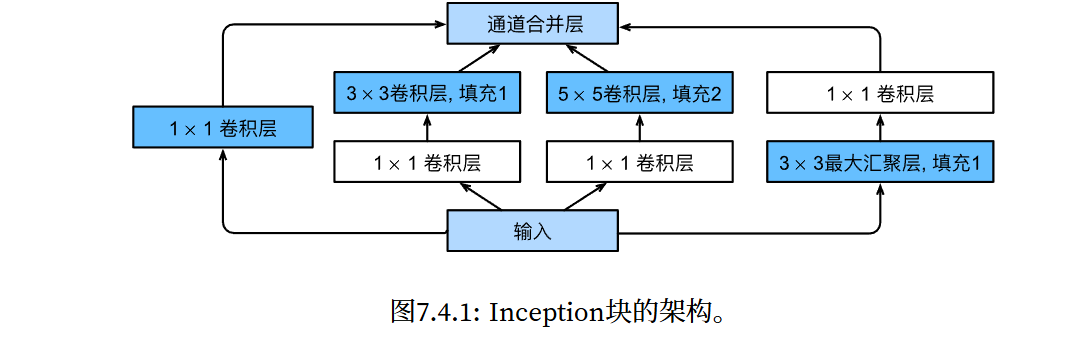

- Inception块由四条并行路径组成。前三条路径使用窗口大小为1 × 1、3 × 3和5 × 5的卷积层，从不同空间大小中提取信息。
- 中间的两条路径在输入上执行1 × 1卷积，以减少通道数，从而降低模型的复杂性。
- 第四条路径使用3 × 3最大汇聚层，然后使用1 × 1卷积层来改变通道数。这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。
- 在Inception块中，通常调整的超参数是每层输出通道数。

In [2]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class Inception(nn.Module):
    #c1--c4是每条路径的输出通道数
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        #在通道维度上联结输出
        return torch.cat((p1,p2,p3,p4),dim=1)

那么为什么GoogLeNet这个网络如此有效呢？
- 首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
- 同时，我们可以为不同的滤波器分配不同数量的参数。

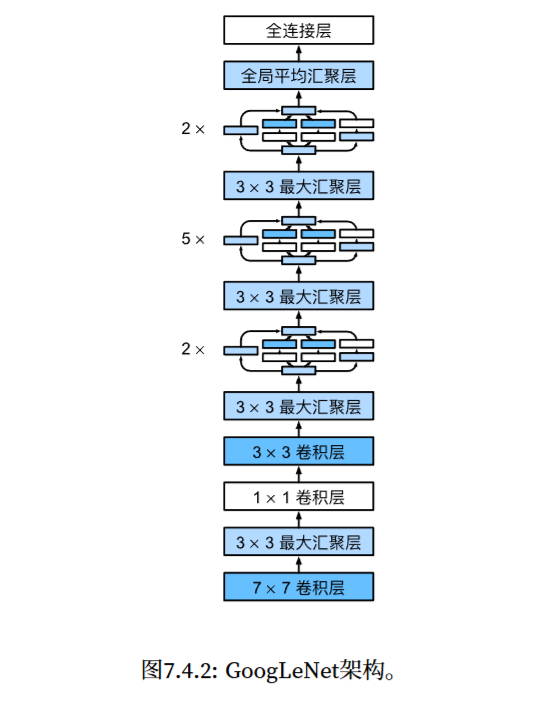

In [4]:
#逐一实现GoogLeNet每个模块
#第一个模块用64个通道，7x7卷积层
b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

In [5]:
#第二个模块使用两个卷积层：第一个卷积层是64个通道、1 × 1卷积层；第二个卷积层使用将通道数量增加三倍的3 × 3卷积层。这对应于Inception块中的第二条路径。
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
#第三个模块串联两个完整的Inception块
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                    Inception(256, 128, (128, 192), (32, 96), 64),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
#第四模块更加复杂，它串联了5个Inception块，这些比例在各个Inception块中都略有不同.
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块包含输出通道数为256 + 320 + 128 + 128 = 832和384 + 384 + 128 + 128 = 1024的两个Inception块。其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。

In [8]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (192, 384), (48, 128), 128),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten())

In [9]:
net=nn.Sequential(b1,b2,b3,b4,b5,nn.Linear(1024,10))

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。为了使Fashion‐MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。下面演示各个模块输出的形状变化。

In [10]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.240, train acc 0.909, test acc 0.899
2179.4 examples/sec on cuda:0


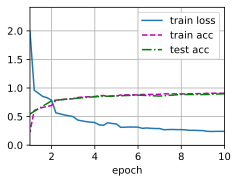

In [11]:
#使用Fashion‐MNIST数据集来训练我们的模型,训练前,我们将图片转换为96 × 96分辨率。
lr,num_epochs,batch_size=0.1,10,128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

小结
- Inception块相当于一个有4条路径的子网络。它通过不同窗口形状的卷积层和最大汇聚层来并行抽取信息，并使用1×1卷积层减少每像素级别上的通道维数从而降低模型复杂度。
- GoogLeNet将多个设计精细的Inception块与其他层（卷积层、全连接层）串联起来。其中Inception块的通道数分配之比是在ImageNet数据集上**通过大量的实验得来的**(~~拿钱砸出来的~~)。
- GoogLeNet和它的后继者们一度是ImageNet上最有效的模型之一：它以较低的计算复杂度提供了类似的测试精度。